- Objective: implement and compare different financial optimization models.
- Assumption : 
    - portfolio_1 : Mean-variance optimization 
    - portfolio_2_1: Robust mean-variance optimization with confidence level 90 %
    - portfolio 2_2:Robust mean-variance optimization with confidence level 95 % 
    - portfolio_3 : Risk Parity optimization with no short selling
    - portfolio_4 : Market (conside the 20 stocks as the market)

In [1]:
# import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
! pip install cvxpy
import cvxpy as cp
from scipy.optimize import minimize
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import data, define tickers for assets and risk free rate.
tickers = ["F", "CAT", "DIS","MCD","KO","PEP","WMT","C","WFC","JPM","AAPL","IBM","PFE","JNJ","XOM",
           "MRO","ED","T","VZ","NEM"]
riskfreerate_tickers = "^TYX"

In [3]:
# define a function to download the data 
def data (ticker,start_date,end_date): 
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)
    monthly_data = data["Adj Close"].resample("M").last()
    monthly_returns = (monthly_data.pct_change()*100).dropna()
    mu = monthly_returns.mean()
    std = monthly_returns.std()
    Q = monthly_returns.cov()
    correlation = np.corrcoef(monthly_returns, rowvar=False)
    return mu,std,Q ,monthly_returns,correlation   

In [4]:
def risk_free_rate (riskfreerate_tickers,start_date,end_date):
    risk_free_rate = yf.download(riskfreerate_tickers, start=start_date, end=end_date, progress=False)
    riskFreeRate = risk_free_rate["Adj Close"].resample("M").last()
    riskFreeRate = (riskFreeRate.pct_change()*100).dropna()
    mu_rfr = riskFreeRate.mean()
    return mu_rfr

### Financail Models

#### (1) Mean-variance optimization (MVO)


\begin{equation}
\begin{array}{rl}
\displaystyle \max_{x} & \mu^Tx - λx^TQx \\
{\rm s.t.} & \ 1^Tx = 1\\
\end{array}
\end{equation}

In [14]:
def MVOM(mu, lambda_val, Q):
    n = len(mu)

    # Define the objective function and change the max to min 
    def objective(x, mu, Q, lambda_val):
        return -np.dot(mu, x) + lambda_val * np.dot(x.T, np.dot(Q, x))

    
    def constraint(x):
        return np.sum(x) - 1

    
    
    x0 = np.ones(n) / n 

    # Define the bounds for x variables, showt selling is allowed
    bounds = [(-np.inf, np.inf)] * n

    
    constraints = [{'type': 'eq', 'fun': constraint}]

    
    result = minimize(objective, x0, args=(mu, Q, lambda_val), method='SLSQP', constraints=constraints, bounds=bounds)
    x_optimal = result.x

    return np.round(x_optimal, decimals=5)

#### (2) Robust mean-variance optimization 

\begin{equation}
\begin{array}{rl}
\displaystyle \max_{x,y} & \mu^Tx - λx^TQx - a^Ty \\
{\rm s.t.} & \ 1^Tx = 1\\
& y \geq x\\
& y \geq -x\\
\end{array}
\end{equation}

In [15]:
def RMVOM (mu, Q, lambda_val, a): 

    def objective(x, y, mu, Q, lambda_val, a):
        return -(np.dot(mu, x) - lambda_val * np.dot(np.dot(x, Q), x) - np.dot(a, y))

    def constraint1(x):
        return np.sum(x) - 1

    def constraint2(x, y):
        return y - x

    def constraint3(x, y):
        return y + x

# Define the initial guess for x and y, the initial guess is random numbers. 
    n = 20  # number of assets
    np.random.seed(123)
    x0 =np.random.random(n)
    y0 = np.random.random(n)

# short selling is allowed
    bounds = [(-np.inf, np.inf)] * n


    constraints = [{'type': 'eq', 'fun': constraint1},
    {'type': 'ineq', 'fun': constraint2, 'args': (x0,)},
    {'type': 'ineq', 'fun': constraint3, 'args': (x0,)}]

    result = minimize(objective, x0, args=(y0, mu, Q, lambda_val, a), method='SLSQP', constraints=constraints, bounds=bounds)

    x_optimal = result.x
    
    return np.round(x_optimal, decimals=5)   

#### (3) Risk Parity optimization (with no short selling)

\begin{equation}
\begin{array}{rl}
\displaystyle \min_{x,θ} & \ ∑ (xi(Qx)i - θ)^2  \\
{\rm s.t.} & \ 1^Tx = 1\\
& x \geq 0
\end{array}
\end{equation}

In [16]:
# Define the objective function
def RPM (Q): 
    def objective(x, Q):
        θ = np.mean(x * (Q @ x))
        return np.sum((x * (Q @ x) - θ)**2)


    def constraint(x):
        return np.sum(x) - 1


    def inequality_constraint(x):
        return x


    n = Q.shape[0]  
    x0 = np.ones(n) / n

# short selling is not allowed
    bounds = [(0, None)] * n

    constraints = [{'type': 'eq', 'fun': constraint},
               {'type': 'ineq', 'fun': inequality_constraint}]


    result = minimize(objective, x0, args=(Q,), method='SLSQP', constraints=constraints, bounds=bounds)

    x_optimal = result.x
    θ_optimal = np.mean(x_optimal * (Q @ x_optimal))

    return np.round(x_optimal, decimals=5)    

#### (4)Market Portfolio

In [17]:
# import Market capitalizations of each stock to calculate market wights, market variance and market return 
market_capitalizations = {'AAPL': 2620000000000,'C': 86825000000,'CAT': 109362000000,'DIS': 161332000000,
    'ED': 32121000000,'F': 48369000000,'IBM': 117038000000,'JNJ': 401114000000,'JPM': 400178000000,
    'KO': 260599000000,'MCD': 208836000000,'MRO': 14365000000,'NEM': 32330000000,'PEP': 252916000000,
    'PFE': 212264000000,'T': 110810000000,'VZ': 147140000000,'WFC': 154704000000,'WMT': 394946000000,
    'XOM': 424392000000}


    
def Market_portfolio (market_capitalizations,Q,mu):
    total_market_cap = sum(market_capitalizations.values())
    weights = np.array([cap / total_market_cap for cap in market_capitalizations.values()])
    wmkt= weights.tolist()
    marketVariance =np.dot(wmkt, np.dot(Q, wmkt))
    marketReturn = np.dot(mu, wmkt)
    return wmkt,marketVariance,marketReturn

#### Part One: December 2007 to June 2011

In [18]:
start_date = "2007-12-31"
end_date = "2011-06-30"
data_1 = data(tickers,start_date,end_date)
riskfreerate_1 = risk_free_rate(riskfreerate_tickers,start_date,end_date)

In [19]:
data_1[3].head(3)

,AAPL,C,CAT,DIS,ED,F,IBM,JNJ,JPM,KO,MCD,MRO,NEM,PEP,PFE,T,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,
2008-01-31,-31.663958,-3.202867,-1.612617,-7.558878,-10.808566,-1.337291,-0.915741,-5.337312,9.544680,-3.861802,-9.047676,-22.658557,11.099781,-10.342520,2.771697,-6.187737,-10.233393,12.885028,6.753634,-8.528106
2008-02-29,-7.638903,-15.832425,1.887582,8.612618,-4.867880,-1.656612,6.708302,-1.218009,-14.240514,-0.915255,1.678242,13.475138,-5.677459,2.218929,-3.275229,-9.508974,-6.464074,-13.349638,-2.266440,1.966799
2008-03-31,14.781597,-9.658361,8.240026,-3.178033,-2.910217,-12.404298,1.124223,4.696622,5.658060,4.792089,3.067877,-14.221246,-11.294861,4.353992,-6.059255,9.962668,0.357900,-0.444750,6.736623,-2.792808


In [20]:
# calculate variance, standard deviation, and  mean return
Q = data_1[2]
std = data_1[1]
mu = data_1[0]
riskfreerate_1
Q

,AAPL,C,CAT,DIS,ED,F,IBM,JNJ,JPM,KO,MCD,MRO,NEM,PEP,PFE,T,VZ,WFC,WMT,XOM
AAPL,130.214171,87.282077,74.747880,53.693461,19.853999,105.236429,33.930029,24.880268,29.499789,17.721222,15.840158,57.122260,-3.126627,17.439234,9.284099,39.377842,33.098259,20.351358,6.543524,20.671210
C,87.282077,516.045866,153.749619,112.215010,41.951477,228.146784,43.920478,56.036638,188.639377,51.785420,49.507335,86.749138,6.901736,52.980815,89.868387,36.174238,32.218166,251.895120,45.416776,32.355364
CAT,74.747880,153.749619,175.588344,76.314827,7.261453,209.244374,41.509061,34.722521,73.464467,42.991065,21.477018,74.005279,46.691872,38.131537,41.430444,51.330211,49.241285,94.792605,28.257095,33.328802
DIS,53.693461,112.215010,76.314827,68.556818,13.422438,114.986339,28.559585,24.483399,50.029021,22.233261,18.997401,56.558865,11.197038,19.810588,27.906877,20.368245,20.526699,69.905680,7.697209,21.009075
ED,19.853999,41.951477,7.261453,13.422438,20.625014,4.721024,6.604068,11.358046,12.238320,7.980506,8.465727,11.418469,-9.811357,9.785833,9.968126,10.643981,12.157845,8.300505,2.226830,6.930957
F,105.236429,228.146784,209.244374,114.986339,4.721024,695.413885,63.413177,32.546477,159.178895,48.556626,16.008722,86.717115,10.363660,38.561106,21.604432,50.374178,57.380851,194.661706,40.613897,32.295862
IBM,33.930029,43.920478,41.509061,28.559585,6.604068,63.413177,37.377855,15.632171,30.465069,11.943671,4.647925,40.973286,10.320129,14.460108,10.193689,6.861102,9.239418,18.633004,8.164920,6.526037
JNJ,24.880268,56.036638,34.722521,24.483399,11.358046,32.546477,15.632171,24.469425,23.121180,15.212249,14.268309,19.518470,14.026607,17.239161,18.523020,12.823438,13.122017,28.985789,9.387267,9.942886
JPM,29.499789,188.639377,73.464467,50.029021,12.238320,159.178895,30.465069,23.121180,125.538703,21.815808,12.378872,26.050567,-16.506954,21.744747,37.987372,15.372184,15.806805,137.669987,26.539362,7.163724
KO,17.721222,51.785420,42.991065,22.233261,7.980506,48.556626,11.943671,15.212249,21.815808,32.267190,14.928231,20.917052,26.936675,22.165254,18.455540,18.529230,17.713763,30.287637,9.914536,12.826116


Text(158.22222222222223, 0.5, 'Assets')

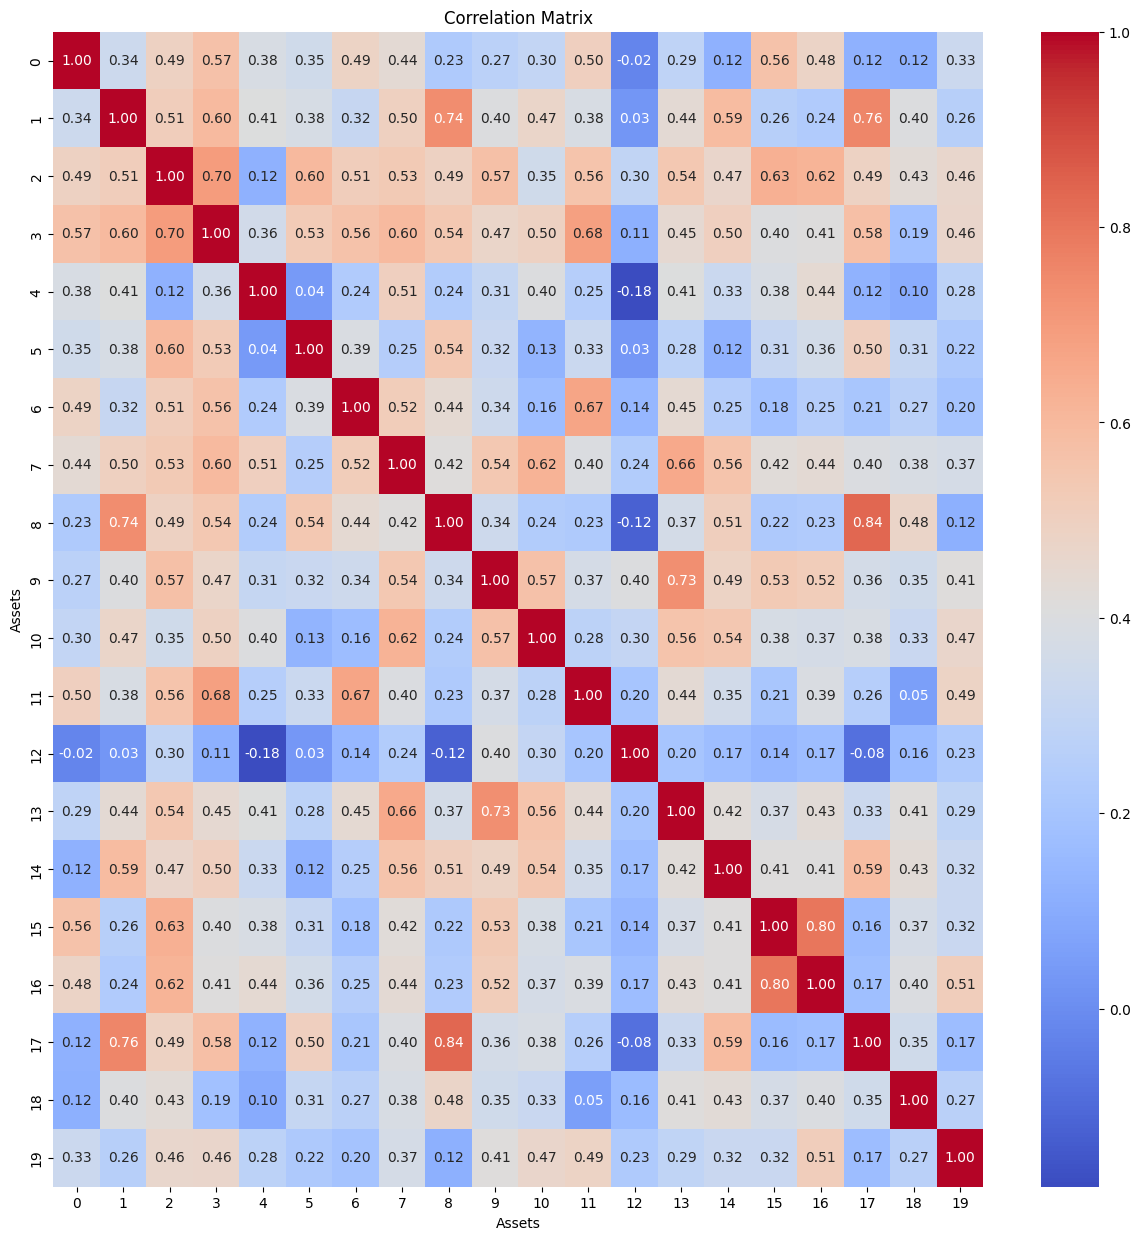

In [21]:
# it shows based on the covariance matrix and the correlation heatmap that assets are not uncorrelated

correlation = data_1[4]
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(correlation, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.xlabel('Assets')
plt.ylabel('Assets')

In [22]:
market_portfolio = Market_portfolio (market_capitalizations,Q,mu)
wmkt = market_portfolio[0]
marketVariance = market_portfolio[1]
marketReturn = market_portfolio[2]

In [23]:
n=20
sigma = []
for i in range(n):
    a = Q.iloc[i,i]
    sigma.append(a)  

In [24]:
std = np.array(sigma)**0.5

In [25]:
# calculate the expected rate of return for efficient assets
a = (marketReturn-riskfreerate_1)/(marketVariance**0.5)
b = riskfreerate_1
ER = []
for i in range (n):
    expected_return = std[i]*a + b
    ER.append(expected_return)

In [26]:
# return of the assets
assets = pd.DataFrame ({"Asset":Q.index,"Return":mu, "Variance":sigma ,"Standard Deviation":std,
                        "Capitalization weights":wmkt ,"Expected_return":ER})
risk_free  = {"Asset":"Risk Free", 'Return': riskfreerate_1,'Variance': 0 ,'Standard Deviation': 0
              ,'Capitalization weights':0,"Expected_return":riskfreerate_1}
assets = assets.append(risk_free,ignore_index=True)

sorted_assets = assets.sort_values(by='Standard Deviation')
sorted_assets = sorted_assets.reset_index(drop=True)
sorted_assets

,Asset,Return,Variance,Standard Deviation,Capitalization weights,Expected_return
0,Risk Free,0.310197,0.000000,0.000000,0.000000,0.310197
1,ED,0.755602,20.625014,4.541477,0.005189,0.878774
2,MCD,1.235516,21.397412,4.625734,0.033740,0.889323
3,JNJ,0.378081,24.469425,4.946658,0.064804,0.929501
4,WMT,0.546008,24.738695,4.973801,0.063808,0.932899
5,PEP,0.195207,28.224872,5.312709,0.040861,0.975329
6,XOM,-0.031444,29.823277,5.461069,0.068565,0.993904
7,KO,0.615544,32.267190,5.680422,0.042102,1.021366
8,VZ,0.398203,36.295584,6.024582,0.023772,1.064453
9,IBM,1.436750,37.377855,6.113743,0.018909,1.075616


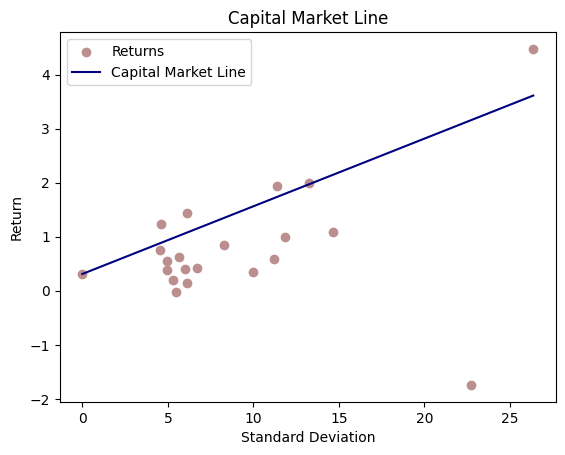

In [27]:
plt.scatter(sorted_assets["Standard Deviation"], sorted_assets["Return"], color='rosybrown' ,label='Returns')

# Plot the line
plt.plot(sorted_assets["Standard Deviation"], sorted_assets["Expected_return"], color='navy', label='Capital Market Line')

# Set labels and title
plt.xlabel('Standard Deviation')
plt.ylabel('Return')
plt.title('Capital Market Line')

# Display the legend
plt.legend()

# Show the plot
plt.show()

In [28]:
# calculate risk aversion value
λ = (marketReturn-riskfreerate_1)/marketVariance
λ

0.018608716741572003

##### Protfolio 1 : MVO

In [29]:
lambda_val=λ
portfolio_1_1 = MVOM(ER,lambda_val,Q)

##### (2-1) RMV (confidence level 90%)

In [30]:
 # T = 42 months 
a = np.zeros((n, n))
for i in range(n):
    a[i, i] = std[i] / (42 ** 0.5)
a = 1.6448536269514722* a
a = np.diag(a)

In [31]:
portfolio_2_1 = RMVOM(mu, Q, lambda_val, a)

##### (2-2) RMVO (confidence level 95%)

In [32]:
a_2 = 1.96* a
portfolio_2_2 = RMVOM(mu, Q, lambda_val, a_2)

##### (3) RPM 

In [33]:
portfolio_3 = RPM (Q)

#### 4) Market Portfolio 

In [34]:
wmkt

[0.42328787727753514,
 0.01402746944451221,
 0.017668552990391526,
 0.026064839624785993,
 0.00518947706337088,
 0.00781450814352561,
 0.018908689534659604,
 0.0648040815291226,
 0.06465286112716392,
 0.04210244180559099,
 0.03373959814470662,
 0.002320813113393814,
 0.005223243157397982,
 0.04086117433951339,
 0.034293426710854474,
 0.01790249224470369,
 0.023771976436113177,
 0.02499401823142893,
 0.06380757785467688,
 0.06856488122655256]

Text(0.5, 1.0, 'Bar Chart of Market Weight')

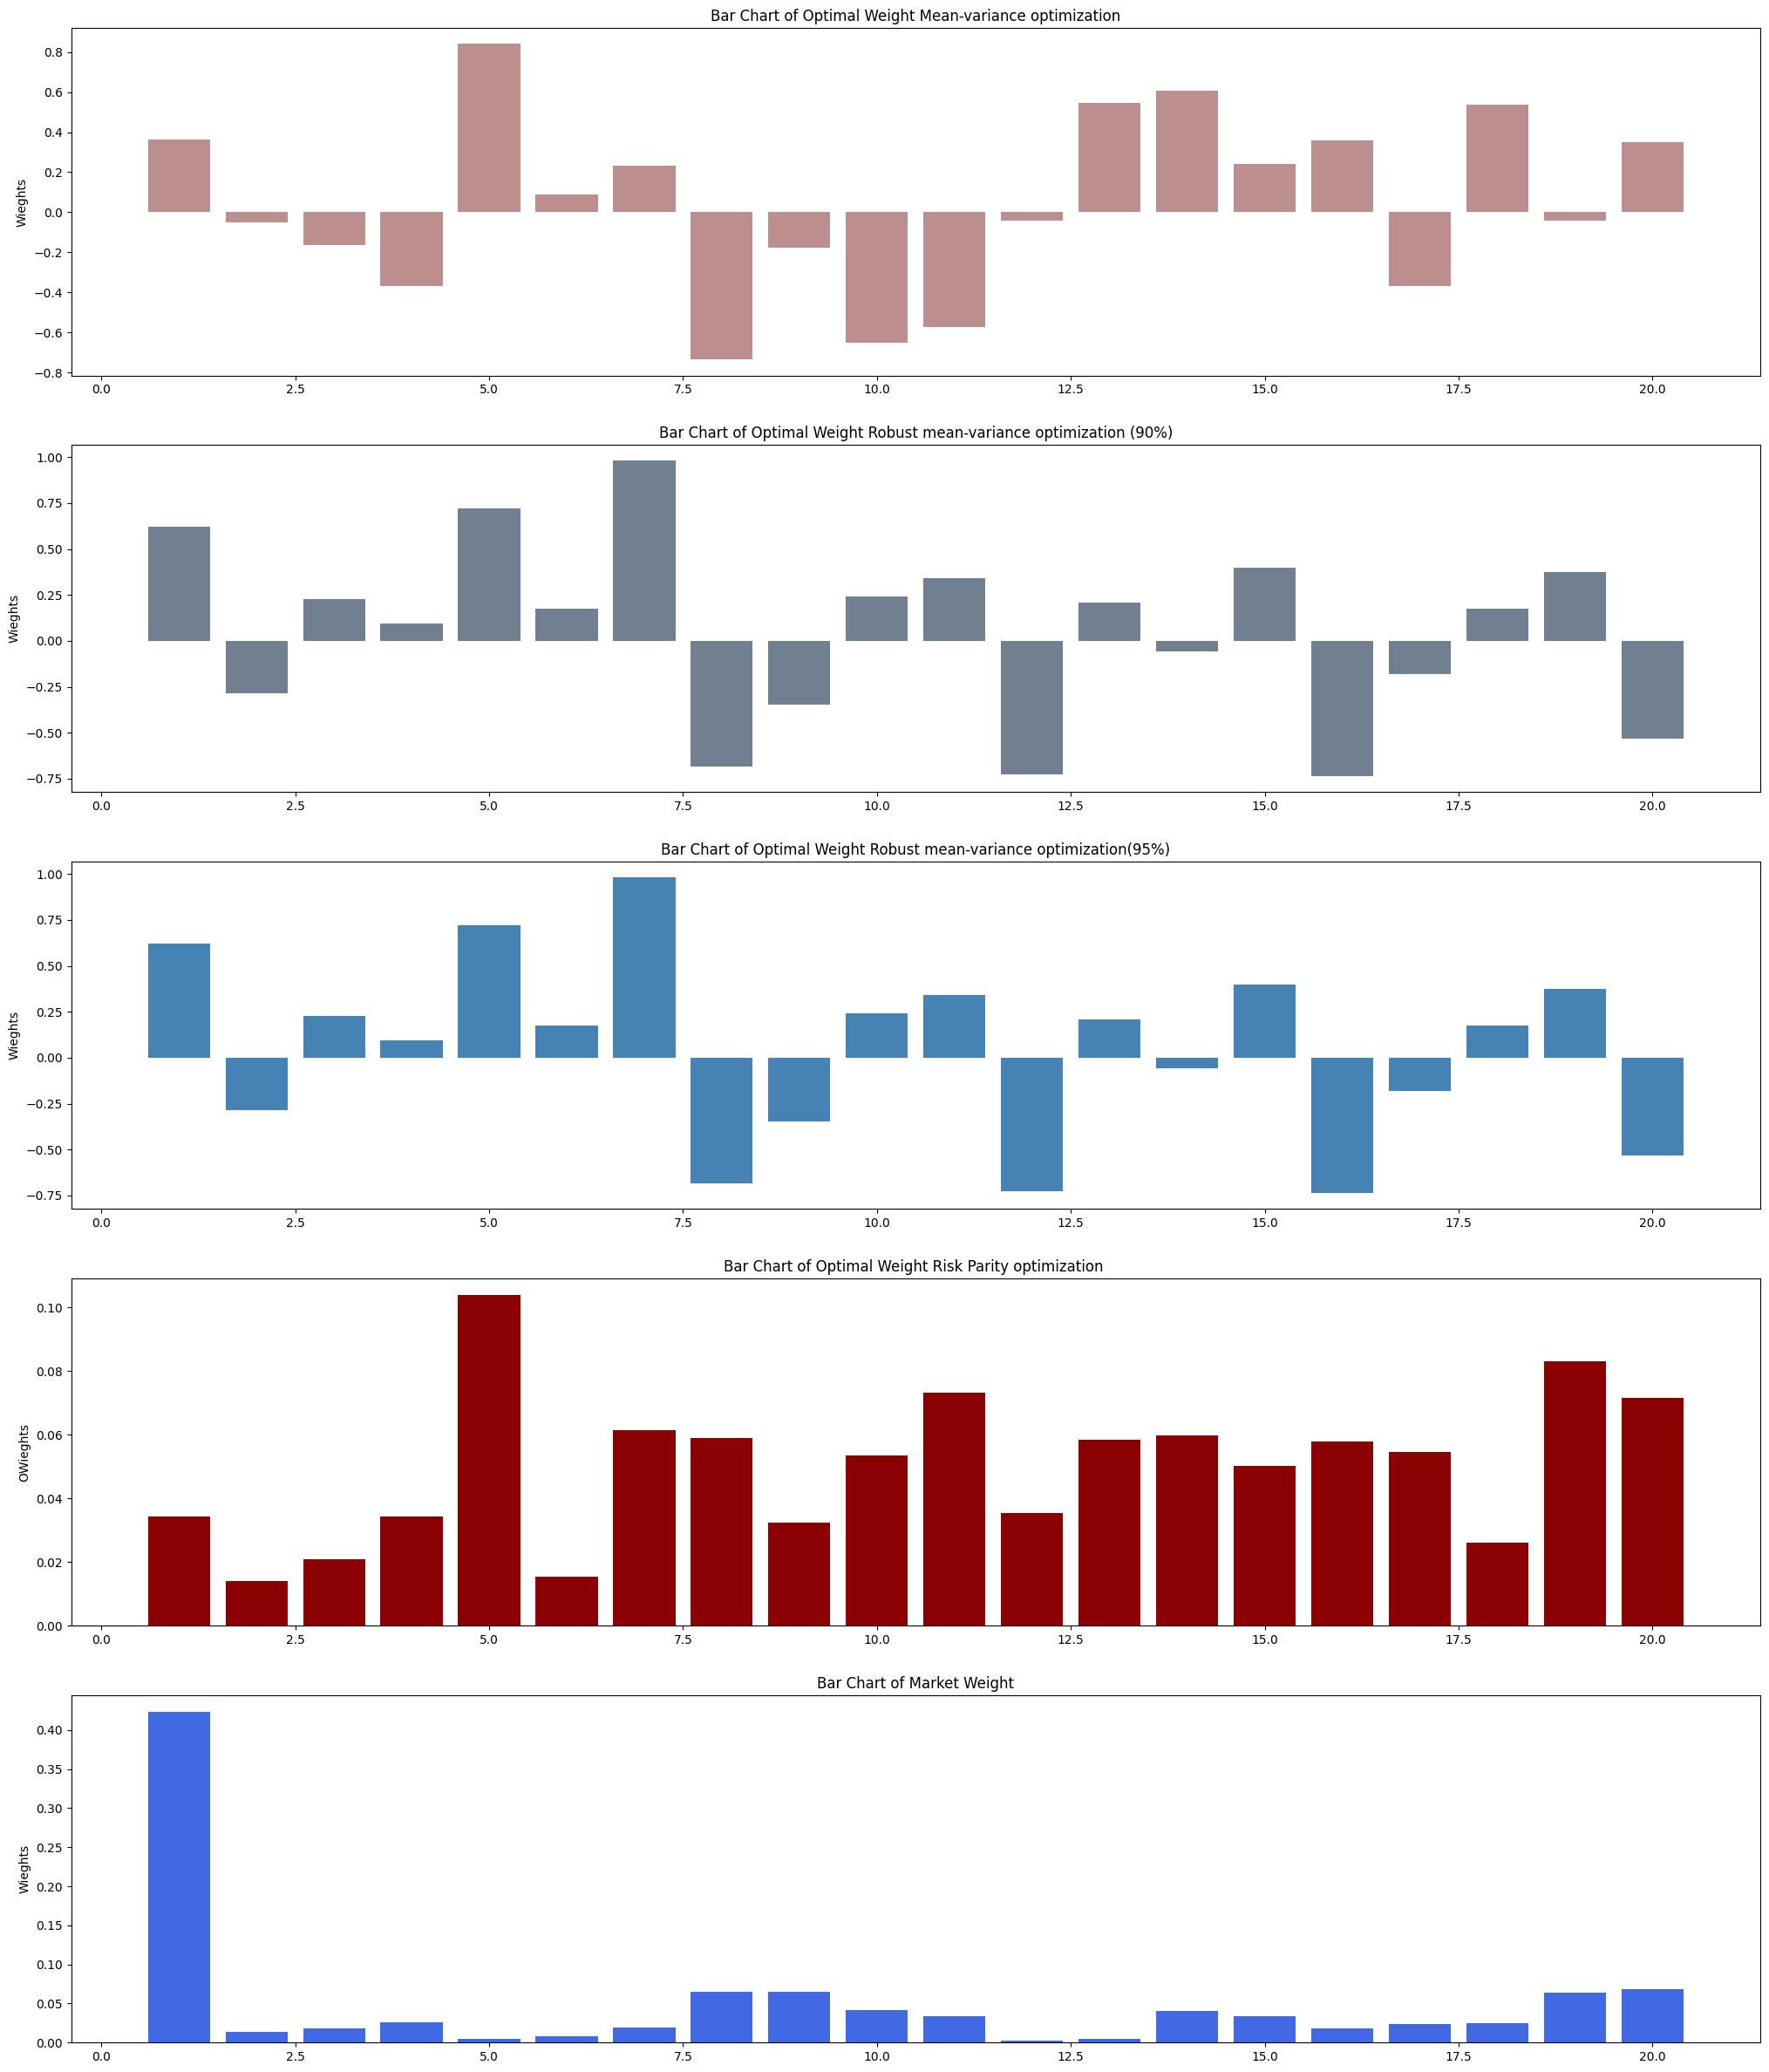

In [35]:
fig, axs = plt.subplots(5, 1, figsize=(25, 30))


indices = np.arange(len(portfolio_1_1)) 
axs[0].bar(indices + 1, portfolio_1_1, color='rosybrown')
axs[0].set_ylabel("Wieghts")
axs[0].set_title("Bar Chart of Optimal Weight Mean-variance optimization")

indices1 = np.arange(len(portfolio_2_1)) 
axs[1].bar(indices1 + 1, portfolio_2_1, color='slategrey')
axs[1].set_ylabel("Wieghts")
axs[1].set_title("Bar Chart of Optimal Weight Robust mean-variance optimization (90%)")

indices2 = np.arange(len(portfolio_2_2))
axs[2].bar(indices2 + 1, portfolio_2_2, color='steelblue')
axs[2].set_ylabel("Wieghts")
axs[2].set_title("Bar Chart of Optimal Weight Robust mean-variance optimization(95%)")

indices3 = np.arange(len(portfolio_3))
axs[3].bar(indices3 + 1, portfolio_3, color='darkred')
axs[3].set_ylabel("OWieghts")
axs[3].set_title("Bar Chart of Optimal Weight Risk Parity optimization ")

wmkt = np.array(wmkt)
indices4 = np.arange(len(wmkt))
axs[4].bar(indices4 + 1, wmkt, color='royalblue')
axs[4].set_ylabel("Wieghts")
axs[4].set_title("Bar Chart of Market Weight")

In [36]:
risk_contribution1 = np.dot(portfolio_1_1,Q)*portfolio_1_1
risk_contribution2 = np.dot(portfolio_2_1,Q)*portfolio_2_1
risk_contribution2_2 = np.dot(portfolio_2_2,Q)*portfolio_2_2
risk_contribution3 = np.dot(portfolio_3,Q)*portfolio_3
risk_contribution4 = np.dot(wmkt,Q)*wmkt

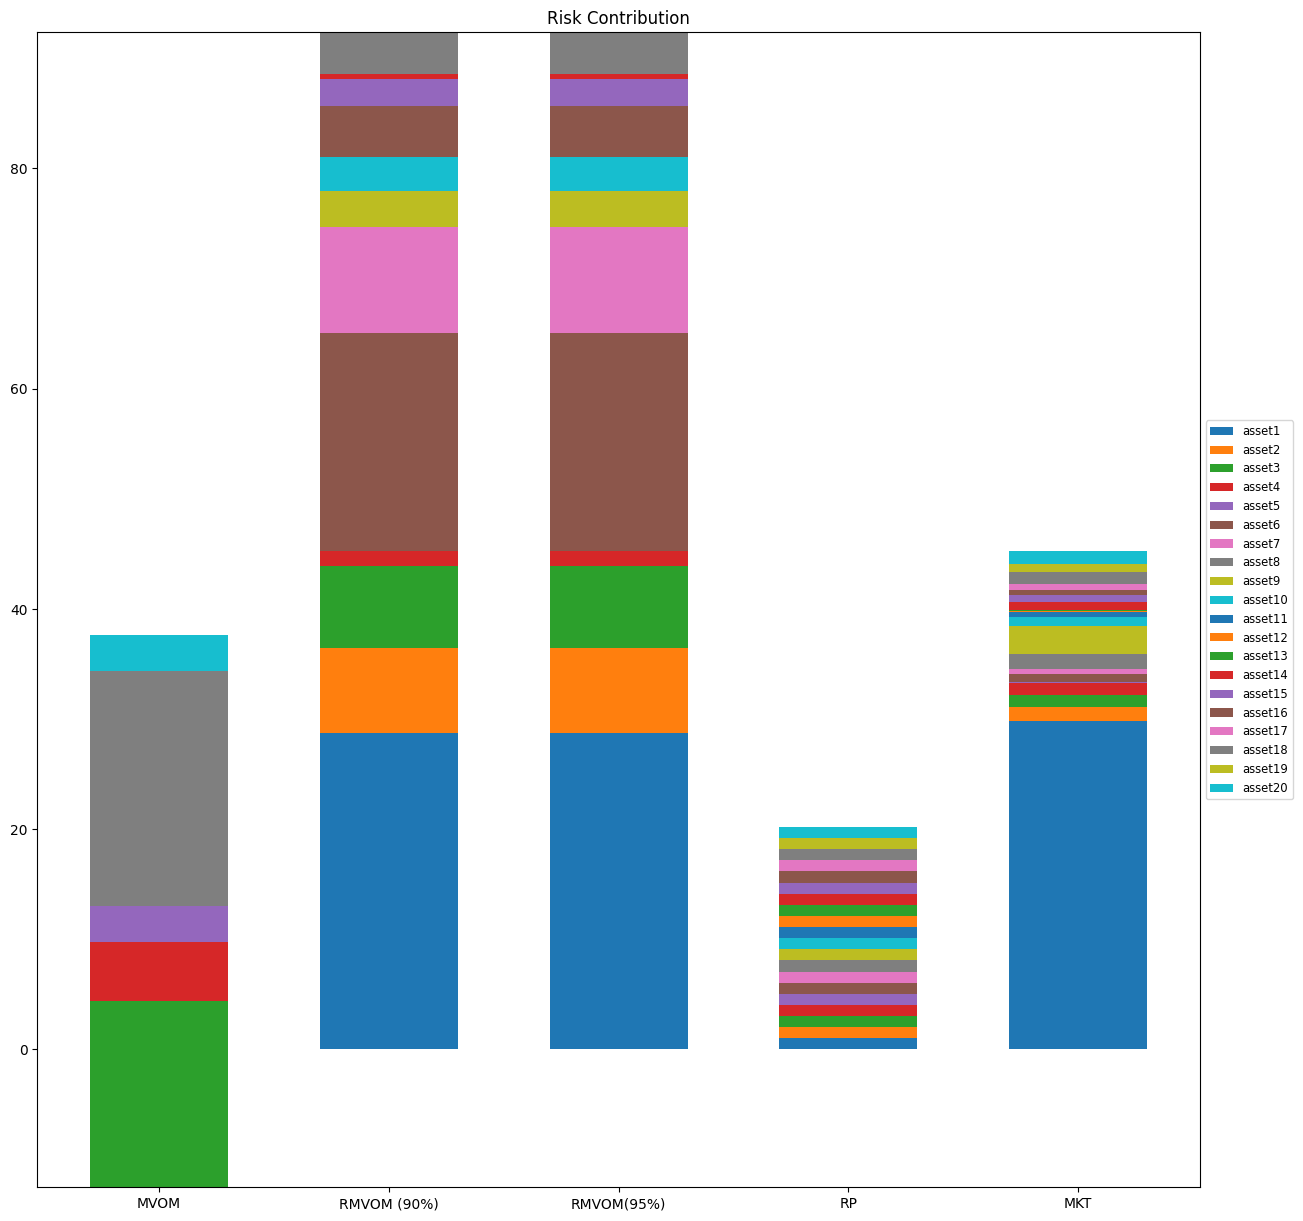

In [37]:
Portfolios = ("MVOM", "RMVOM (90%)", "RMVOM(95%)", "RP", "MKT")
risk_contribution = {}

for i in range(n):
    rc = {"asset" + str(i+1): np.array([risk_contribution1[i], risk_contribution2[i]
                                       , risk_contribution2_2[i], risk_contribution3[i],
                                        risk_contribution4[i]])}
    risk_contribution.update(rc)
    
    
width = 0.6  # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots(figsize=(15, 15))
bottom = np.zeros(5)

for asset, relative_risk_contribution in risk_contribution.items():
    p = ax.bar(Portfolios, relative_risk_contribution, width, label=asset, bottom=bottom)
    bottom += relative_risk_contribution

    

ax.set_title('Risk Contribution')
ax.legend( loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

plt.show() 

In [38]:
start_date = "2011-05-29"
end_date = "2011-07-01"
return_July_2011= data (tickers,start_date,end_date)
july_return = return_July_2011[0]

In [39]:
def portfolios(weights,mu, cov_matrix):
    portfolio_return= np.sum(july_return*weights)
    portfolio_variance = weights.T @ (weights@ cov_matrix)
    portfolio_std = portfolio_variance ** 0.5
    sharpe_ratio =  portfolio_return/portfolio_std
    print ("portfolio_return =" ,portfolio_return,"portfolio_variance=",portfolio_variance,
           "portfolio_std=" ,portfolio_std,"sharpe_ratio=" ,sharpe_ratio)
    return portfolio_return,portfolio_variance,portfolio_std,sharpe_ratio
    

In [40]:
MVMO = portfolios(portfolio_1_1,july_return, Q)

portfolio_return = -5.347810333298089 portfolio_variance= 37.636273062994654 portfolio_std= 6.134840915866903 sharpe_ratio= -0.8717113298678585


In [41]:
RMVOM_90 = portfolios(portfolio_2_1,july_return,Q)

portfolio_return = 1.1332067065433196 portfolio_variance= 81.06800969730413 portfolio_std= 9.003777523756577 sharpe_ratio= 0.125859030118563


In [42]:
RMVOM_95 = portfolios(portfolio_2_2,july_return,Q)

portfolio_return = 1.1332067065433196 portfolio_variance= 81.06800969730413 portfolio_std= 9.003777523756577 sharpe_ratio= 0.125859030118563


In [43]:
RP = portfolios(portfolio_3,july_return,Q)

portfolio_return = -1.265202668873993 portfolio_variance= 20.211535859752104 portfolio_std= 4.495724175230516 sharpe_ratio= -0.2814235525935308


In [44]:
wmkt=np.array(wmkt)
MKT = portfolios(wmkt,july_return,Q)

portfolio_return = -2.487455360722303 portfolio_variance= 45.26380535945565 portfolio_std= 6.727838089569015 sharpe_ratio= -0.3697258060622635


In [45]:
portfolio = pd.DataFrame ({"Return":[MVMO[0],RMVOM_90[0],RMVOM_95[0],RP[0],MKT[0]],
                           "Variance":[MVMO[1],RMVOM_90[1],RMVOM_95[1],RP[1],MKT[1]],
                           "Standard Deviation":[MVMO[2],RMVOM_90[2],RMVOM_95[2],RP[2],MKT[2]],
                           "Sharpe Ratio": [MVMO[3],RMVOM_90[3],RMVOM_95[3],RP[3],MKT[3]]})
portfolio_July_2011 = portfolio.rename(index={0: 'Mean Variance',
                                   1:"Robust Mean Varian(90%)",
                                   2:"Robust Mean Varian(95%)",
                                   3: "Risk Parity",
                                   4: "Market Cap"})
portfolio_July_2011

,Return,Variance,Standard Deviation,Sharpe Ratio
Mean Variance,-5.347810,37.636273,6.134841,-0.871711
Robust Mean Varian(90%),1.133207,81.068010,9.003778,0.125859
Robust Mean Varian(95%),1.133207,81.068010,9.003778,0.125859
Risk Parity,-1.265203,20.211536,4.495724,-0.281424
Market Cap,-2.487455,45.263805,6.727838,-0.369726
